<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Authors: [Vitaly Radchenko](https://www.linkedin.com/in/vitaliyradchenk0/), Data Scientist at YouScan, and , Data Scientist at Mail.ru Group <br>
Translated and edited by [Yury Kashnitskiy](https://www.linkedin.com/in/festline/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Anna Shirshova](http://linkedin.com/in/anna-shirshova-b908458b), [Artem Trunov](https://www.linkedin.com/in/datamove/),  and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/).

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center>Assignment # 5</center>
## <center>Logistic Regression and Random Forest in the credit scoring problem</center>  

In this assignment, you will build models and answer questions using data on credit scoring.

Please write your code in the cells with the "Your code here" placeholder. Then, answer some questions in this [form](https://drive.google.com/open?id=1P9SAkIRUiznVJd1bzAqRG5AoIpwPfUo3SHfQtDV_tPw).

Let's start with a warm-up exercise.

**Question 1.** There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is made by majority vote?

1. 70.00%
2. 83.20%
3. 83.70%
4. 87.50%

#### Below function will calcuate the probablity by taking number of jurors and the probabality of correct decision made by an individual juror

In [27]:
from scipy.special import comb
def prob_calc(n_juror = None, ind_prob = None):
    n_majority = int(n_juror/2) +1
    final_prob = 0
    while n_majority <= n_juror:
        final_prob += comb(n_juror, n_majority) * (ind_prob**n_majority) * ((1-ind_prob)**(n_juror-n_majority))
        #print(final_prob, n_majority)
        n_majority += 1        
        
    return final_prob*100

In [28]:
prob_calc(5,0.7)

83.691999999999993

#### Mathematically, probabality can be calculated as:

Probabality = (5C3) * .7^3 * .3^2 + (5C4) * .7^4 * .3^1 + (5C5) * .7^5 * .3^0 = 0.8369 ~ 83.7%

Great! Let's move on to machine learning.

## Credit scoring problem setup

#### Problem

Predict whether the customer will repay his/her credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [29]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [30]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

Let's write the function that will replace *NaN* values with a median for each column.

In [31]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

Now, read the data:

In [32]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Look at the variable types:

In [37]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check target variable distribution:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

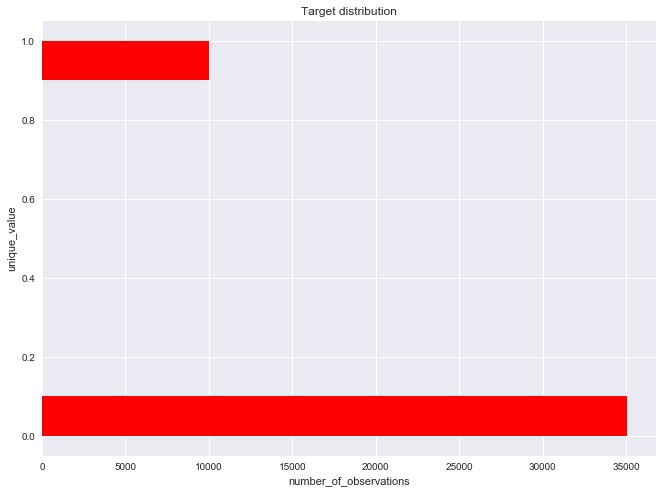

In [38]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Apply the function to replace *NaN* values:

In [39]:
table = fill_nan(data)

Separate the target variable and input features:

In [40]:
X = table.drop('SeriousDlqin2yrs', axis=1)
y = table['SeriousDlqin2yrs']

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as it was done in the article. What is the resulting interval estimate?

1. 52.59 – 52.86
2. 45.71 – 46.13
3. 45.68 – 46.17
4. 52.56 – 52.88

#### Since our sample is not large, we resort to bootstrapping and finding the average by taking mean of the bootstrapped samples.

Then, we find the CI for our estimate

In [30]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the data about the customers who delayed loan repayment
delayed_loan_payee_age = table[table['SeriousDlqin2yrs'] == 1]['age'].values

# Set the seed for reproducibility of the results
np.random.seed(0)

# Generate the samples using bootstrapping and calculate the mean for each of them
delayed_loan_payee = [np.mean(sample) 
                       for sample in get_bootstrap_samples(delayed_loan_payee_age, 1000)]


# Print the resulting interval estimates
print("Age of Customers who delayed loan payment: mean interval", stat_intervals(delayed_loan_payee, 0.10))

Age of Customers who delayed loan payment: mean interval [ 45.71379414  46.12700479]


#### Therefore, average age of customers who delayed loan payment is 45.7 - 46.13 with 90% CI.

## Logistic regression

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [42]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [43]:
parameters_logit = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal? 

1. 0.0001
2. 0.001
3. 0.01
4. 0.1
5. 1
6. 10

In [45]:
%%time
from sklearn.model_selection import GridSearchCV

#param_grid_logit = {'logisticregression__C': parameters}
grid_logit = GridSearchCV(lr, parameters_logit, scoring='roc_auc', cv=skf, n_jobs=-1)

grid_logit.fit(X, y)

Wall time: 39.4 s


In [46]:
grid_logit.best_params_, grid_logit.best_score_

({'C': 0.001}, 0.79540943969438627)

#### Best score is  `0.7954`, with regularization coefficient of `0.001`

**Question 4.** Can we consider the best model stable? Let's call the model *stable* if standard deviation of it's scores in cross-validation is less than $5*10^{-3}$. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

1. Yes
2. No

In [59]:
grid_logit.cv_results_['std_test_score'][grid_logit.cv_results_['params'].index({'C':0.001})]

0.0063574409759387133

Standard deviation of test score for the best model (with C = 0.001) is **not less than 0.005.**
Therefore, our model is **not stable**

## Feature importance

**Question 5.** *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them (here you resort to `StandardScaler`). What is the most important feature for the best logistic regression model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [159]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

logit_scaled = LogisticRegression(random_state=0,C=0.001,n_jobs=-1)
logit_scaled.fit(X_scaled,y)

pd.DataFrame({"Features" : X.columns, "Co-efficients" : logit_scaled.coef_[0]})

,Co-efficients,Features
0,-0.364257,age
1,0.418302,NumberOfTime30-59DaysPastDueNotWorse
2,-0.019579,DebtRatio
3,0.260518,NumberOfTimes90DaysLate
4,-0.016561,NumberOfTime60-89DaysPastDueNotWorse
5,-0.153739,MonthlyIncome
6,0.101251,NumberOfDependents


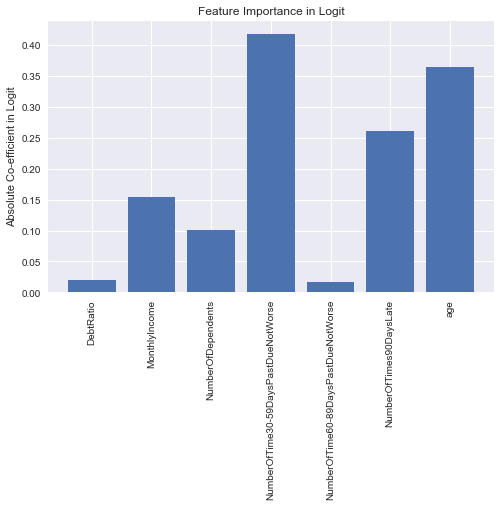

In [165]:
plt.figure(figsize=(8,5))
plt.bar(X.columns.values, np.absolute(logit_scaled.coef_[0]))
plt.xticks(rotation = 90)
plt.ylabel("Absolute Co-efficient in Logit")
plt.title("Feature Importance in Logit")
plt.show()

#### We can see that absolute values of co-efficients from the logistic regression model is highest for "NumberOfTime30-59DaysPastDueNotWorse"

**Question 6.** What's the effect of  `DebtRatio` on the prediction made with Logistic regression? Calculate this with the [softmax function](https://en.wikipedia.org/wiki/Softmax_function)

1. 0.38
2. -0.02
3. 0.11
4. 0.24

In [168]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / np.sum(e_x)

pd.DataFrame({"Features" : X.columns.values, "Effect on Odds Ratio (using Softmax)" : softmax(logit_scaled.coef_[0])})

,Effect on Odds Ratio (using Softmax),Features
0,0.093376,age
1,0.204220,NumberOfTime30-59DaysPastDueNotWorse
2,0.131804,DebtRatio
3,0.174410,NumberOfTimes90DaysLate
4,0.132202,NumberOfTime60-89DaysPastDueNotWorse
5,0.115256,MonthlyIncome
6,0.148732,NumberOfDependents


In [169]:
print((np.exp(logit_scaled.coef_[0]) / np.sum(np.exp(logit_scaled.coef_[0])))[2])

0.131803874734


#### Therefore, DebtRatio's effect on OR is 0.13

**Question 7.** Let's see how we can interpret the impact of our features. For this, re-train logistic regression with original features, that is, not scaled. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. You'll have two estimates for odds of this customer being bad – with original age and with aged increased by 20 years. What's the quotient of this odds? (the second divided by the first). That is, you'll find how more or less likely it is that a customer won't repay his/her credit if he/she were 20 years older. You can find some material on interpreting logistic regression coefficients [here](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

1. -0.01
2. 0.70
3. 8.32
4. 0.66

In [154]:
retrain_logit = LogisticRegression(C=0.001, random_state=0, class_weight='balanced', n_jobs=-1)
retrain_logit.fit(X,y)

pd.DataFrame({"Features" : X.columns.values, "Coefficients from Logit" : retrain_logit.coef_[0]}).sort_values(by='Coefficients from Logit')

,Coefficients from Logit,Features
0,-0.018185,age
5,-0.000011,MonthlyIncome
2,-0.000011,DebtRatio
4,0.065958,NumberOfTime60-89DaysPastDueNotWorse
6,0.115356,NumberOfDependents
3,0.430314,NumberOfTimes90DaysLate
1,0.482349,NumberOfTime30-59DaysPastDueNotWorse


#### From the above reference article, we know that for every unit increase in value of Age, the odds ratio increases by exp(coefficient of Age) 

Therefore, if Age is increased by 20 years, OR should increase by:

In [138]:
OR = np.exp(retrain_logit.coef_[0][X.columns.get_loc('age')] * 20)
OR

0.69509577855481552

#### Therefore, if Age increases by 20 years, OR increases by 0.70

## Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [140]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')

We are going to search for the best hyperparameters among these values:

In [141]:
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

Also, we will use stratified k-fold validation again. You should still have the `skf` variable defined.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation? Use `GridSearchCV` and it's attribute `best_score_`.

1. 0.04
2. 0.03
3. 0.02
4. 0.01

In [142]:
%%time

#param_grid_logit = {'logisticregression__C': parameters}
grid_rf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)

grid_rf.fit(X, y)

Wall time: 5min 32s


In [143]:
grid_rf.best_score_

0.83505572749942492

#### We can clearly see improvement in random forest best score.

ROC AUC for randomforest is higher than that by logistic regression by:

In [144]:
grid_rf.best_score_ - grid_logit.best_score_

0.039646287805038649

Random Forest improves the best score from logistic regression by **0.04**

**Question 9.** What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [145]:
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

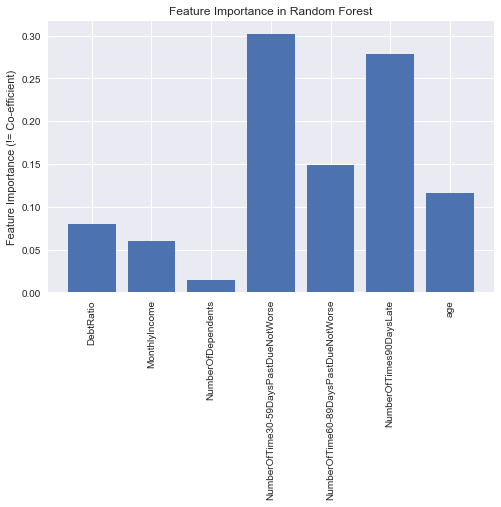

In [166]:
forest = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

forest.fit(X, y)
importances = forest.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(X.columns.values, np.absolute(importances))
plt.xticks(rotation = 90)
plt.ylabel("Feature Importance (!= Co-efficient)")
plt.title("Feature Importance in Random Forest")
plt.show()

#### We can see that `Number of Dependents` has the least importance/impact on RandomForest model with the least importance score of 0.01433692

**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. Feature interpretability;
4. Linear properties of the algorithm.

**Feature Interpretability** is the biggest advantage that Logistic Regression has over Random Forest.

On the one hand, the Random Forest model works better for our credit scoring problem. Its performance is 4% higher. The reason for such a result is a small number of features and the ability of random forests to build non0linear decision functions.

On the other hand, the main advantage of Logistic Regression is that we can interpret the feature impact on the model outcome.

## Bagging

Import modules and set up the parameters for bagging:

In [147]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters_bag = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. 80.75%
2. 80.12%
3. 79.62%
4. 76.50%

In [148]:
bagcf = BaggingClassifier(LogisticRegression(random_state=42, class_weight='balanced'),n_estimators=100, random_state=42)

In [150]:
%%time
grid_rsf = RandomizedSearchCV(bagcf, parameters_bag, scoring='roc_auc', cv=skf, n_jobs=-1, n_iter=20, random_state=42)

grid_rsf.fit(X,y)

Wall time: 14min 1s


In [151]:
grid_rsf.best_score_, grid_rsf.best_params_

(0.80599280597956724,
 {'base_estimator__C': 0.01, 'max_features': 2, 'max_samples': 0.7})

#### Best ROC AUC, using bagging with 100 Logistic Classifiers as base model, is 0.806 or 80.7%

**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

1. For bagging it's important to use as few features as possible;
2. Bagging works better on small samples;
3. Less correlation between single models;
4. The higher the number of features, the lower the loss of information.

**Answer:** 3.

**Solution:**

The advantage of *Random Forest* is that the trees in the composition are not highly correlated. Similarly, for bagging with logistic regression, the weaker correlation between single models, the higher the accuracy. Since in logistic regression there is almost no randomness, we have to change the set of features to minimize the correlation between our single models.